# Trend Analysis between Financial News and Stock Prices
#### Group members: Akshita Chandiramani, Ruchita Jadhav, Sanjeev Ramasamy

Fluctuations in stock prices are based on supply and demand of that stock. This affiliation is tangled with the type of news that is issued at any time. News regarding any firm influences the price of their stocks. Positive news creates a good impression regarding the firm and causes investors to buy stocks, thereby increasing the demand. This, in turn, increases the price of the stock. Negative news, on the other hand, such as a poor earnings report, political uncertainty, or a scandal will cause the investors to sell stocks which transforms into a decrease in stock price.

We aim to derive a quantifiable relationship between financial news and stock prices and predict stock prices of a firm based on analysis of financial news of that firm. This will help investors and firms in understanding the impact of a particular news on stock prices.

## Models performed:
#### 1) Logistic Regression to predict Daily Return fluctuation (binary outcome) using TF-IDF output of financial news
#### 2) Logistic Regression to predict Daily Return fluctuation (binary outcome) using average sentiment of financial news
#### 3) Linear Regression to predict Daily Return using TF-IDF output of financial news
#### 4) Linear Regression to predict Daily Return using average sentiment of financial news

## Loading Required Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.ml.feature import MinMaxScaler, StandardScaler
from pyspark.sql import functions as fn, Row, Column as col
from pyspark.sql.functions import length, regexp_replace
import matplotlib.pyplot as plt
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.sql import functions as fn
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer, CountVectorizer, RegexTokenizer
from pyspark.ml import Pipeline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pyspark.sql.window import Window
from pyspark.sql.functions import lit
from pyspark.sql import SQLContext as sqlContext
from pyspark.ml.feature import RegexTokenizer
import pandas as pd
import time
import numpy as np
from pyspark.sql.types import *

## Data processing

### Reading financial news data for Apple, Microsoft and IBM (10,000 articles per company)

In [2]:
AAPL_news = pd.read_csv('AAPL_news.csv')
MSFT_news = pd.read_csv('MSFT_news.csv')
IBM_news = pd.read_csv('IBM_news.csv')

In [3]:
AAPL_news = AAPL_news[['publication_date','title','summary']].astype(str)
AAPL_news["Company"] = "AAPL"
MSFT_news = MSFT_news[['publication_date','title','summary']].astype(str)
MSFT_news["Company"] = "MSFT"
IBM_news = IBM_news[['publication_date','title','summary']].astype(str)
IBM_news["Company"] = "IBM"

frames = [AAPL_news, MSFT_news, IBM_news]
news_dataframe = pd.concat(frames, sort=False)
news_spark_df = spark.createDataFrame(news_dataframe)


news_spark_df = news_spark_df.withColumn('summary', regexp_replace('summary', '&apos;', "'"))
news_spark_df = news_spark_df.withColumn('title', regexp_replace('title', '&apos;', "'"))

news_spark_df = news_spark_df.withColumn('all_text', fn.concat(fn.col('title'),fn.lit(' '), fn.col('summary')))

In [4]:
news_spark_df = news_spark_df.withColumn('Date', news_spark_df['publication_date'].substr(1, 10))
news_spark_df = news_spark_df.drop('publication_date')
news_spark_df = news_spark_df.distinct()
news_spark_df = news_spark_df.sort('Date', ascending= False)
regex = "([0-9]{4}-[0-9]{2}-[0-9]{2})"
news_spark_df = news_spark_df.where(fn.col("Date").rlike(regex))

### Reading stock prices data for Apple, Microsoft and IBM

In [5]:
AAPL_stocks = pd.read_csv('AAPL_stocks.csv')
MSFT_stocks = pd.read_csv('MSFT_stocks.csv')
IBM_stocks = pd.read_csv('IBM_stocks.csv')

In [6]:
AAPL_stocks = AAPL_stocks[['date','open','close']].astype(str)
AAPL_stocks["Company"] = "AAPL"
MSFT_stocks = MSFT_stocks[['date','open','close']].astype(str)
MSFT_stocks["Company"] = "MSFT"
IBM_stocks = IBM_stocks[['date','open','close']].astype(str)
IBM_stocks["Company"] = "IBM"

frames = [AAPL_stocks, MSFT_stocks, IBM_stocks]
stocks_dataframe = pd.concat(frames, sort=False)
stocks_spark_df = spark.createDataFrame(stocks_dataframe)

stocks_spark_df = stocks_spark_df.withColumn("close", stocks_spark_df["close"].cast("double"))
stocks_spark_df = stocks_spark_df.withColumn("date", stocks_spark_df["date"].cast("date"))

### Visualizing Apple's closing prices across dates

[Text(0,0.5,'Closing Price'), Text(0.5,0,'Date')]

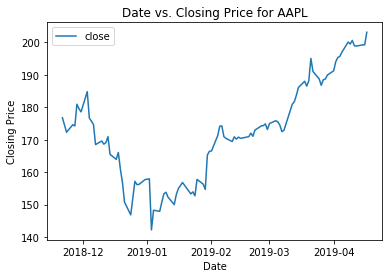

In [7]:
stocks_spark_df_AAPL = stocks_spark_df.where("Company == 'AAPL'")
plt = stocks_spark_df_AAPL.toPandas().plot(x='date',y='close', title = 'Date vs. Closing Price for AAPL')
plt.set(xlabel="Date", ylabel="Closing Price")

### Visualizing Microsoft's closing prices across dates

[Text(0,0.5,'Closing Price'), Text(0.5,0,'Date')]

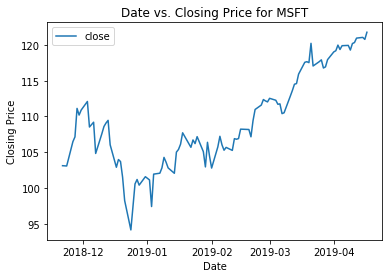

In [8]:
stocks_spark_df_MSFT = stocks_spark_df.where("Company == 'MSFT'")
plt = stocks_spark_df_MSFT.toPandas().plot(x='date',y='close', title = 'Date vs. Closing Price for MSFT')
plt.set(xlabel="Date", ylabel="Closing Price")

### Visualizing IBM's closing prices across dates

[Text(0,0.5,'Closing Price'), Text(0.5,0,'Date')]

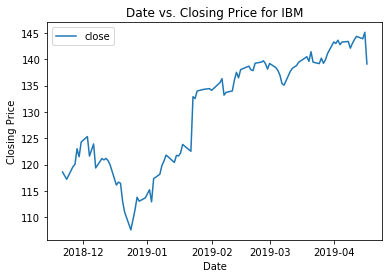

In [9]:
stocks_spark_df_IBM = stocks_spark_df.where("Company == 'IBM'")
plt = stocks_spark_df_IBM.toPandas().plot(x='date',y='close', title = 'Date vs. Closing Price for IBM')
plt.set(xlabel="Date", ylabel="Closing Price")

### Calculating Daily Return values for Apple, Microsoft and IBM

In [10]:
stocks_spark_df = stocks_spark_df.withColumn('Previous Close', fn.lag(stocks_spark_df['Close']).over(Window.partitionBy('Company').orderBy('Date')))
stocks_spark_df = stocks_spark_df.withColumn('Daily Return', ((stocks_spark_df['Close'] - stocks_spark_df['Previous Close'])/stocks_spark_df['Close']) * 100 )
stocks_spark_df = stocks_spark_df.select("Company", "Date", "Close","Daily Return")

stocks_spark_df = stocks_spark_df.withColumn("Daily Return", stocks_spark_df["Daily Return"].cast("double"))
stocks_spark_df = stocks_spark_df.withColumn("date", stocks_spark_df["date"].cast("date"))

### Visualizing Apple's daily return across dates

[Text(0,0.5,'Daily Return'), Text(0.5,0,'Date')]

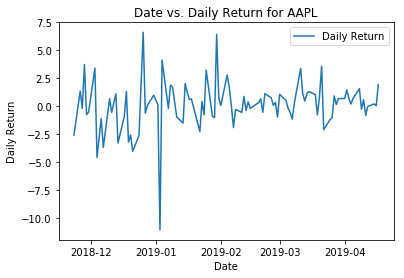

In [11]:
stocks_spark_df_AAPL = stocks_spark_df.where("Company == 'AAPL'")
plt = stocks_spark_df_AAPL.toPandas().plot(x='date',y='Daily Return', title = 'Date vs. Daily Return for AAPL')
plt.set(xlabel="Date", ylabel="Daily Return")

### Visualizing Microsoft's daily return across dates

[Text(0,0.5,'Daily Return'), Text(0.5,0,'Date')]

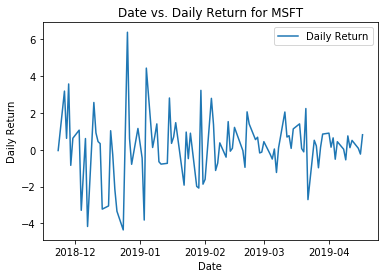

In [12]:
stocks_spark_df_MSFT = stocks_spark_df.where("Company == 'MSFT'")
plt = stocks_spark_df_MSFT.toPandas().plot(x='date',y='Daily Return', title = 'Date vs. Daily Return for MSFT')
plt.set(xlabel="Date", ylabel="Daily Return")

### Visualizing IBM's daily return across dates

[Text(0,0.5,'Daily Return'), Text(0.5,0,'Date')]

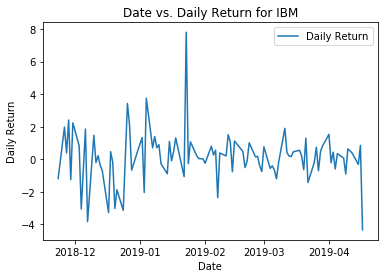

In [13]:
stocks_spark_df_IBM = stocks_spark_df.where("Company == 'IBM'")
plt = stocks_spark_df_IBM.toPandas().plot(x='date',y='Daily Return', title = 'Date vs. Daily Return for IBM')
plt.set(xlabel="Date", ylabel="Daily Return")

### Combining financial news with stock prices (Today's news with tomorrow's stock price)

In [14]:
news_spark_df = news_spark_df.withColumn('Next_Date', fn.date_add(news_spark_df['Date'], 1))

In [15]:
news_spark_df.show(2)

+--------------------+--------------------+-------+--------------------+----------+----------+
|               title|             summary|Company|            all_text|      Date| Next_Date|
+--------------------+--------------------+-------+--------------------+----------+----------+
|Edited Transcript...|Q1 2019 Internati...|    IBM|Edited Transcript...|2019-04-18|2019-04-19|
|Sony's PlayStatio...|The first details...|   MSFT|Sony's PlayStatio...|2019-04-18|2019-04-19|
+--------------------+--------------------+-------+--------------------+----------+----------+
only showing top 2 rows



In [16]:
combined_data = news_spark_df.join(stocks_spark_df, (news_spark_df.Next_Date == stocks_spark_df.date) & (news_spark_df.Company == stocks_spark_df.Company))
combined_data = combined_data.drop(news_spark_df.Date)
combined_data = combined_data.drop(stocks_spark_df.Company)
combined_data = combined_data.drop(stocks_spark_df.Close)
combined_data = combined_data.drop(news_spark_df.Next_Date)
combined_data = combined_data.select("date","company","all_text","Daily Return",
                                     fn.when(combined_data['Daily Return']>0, 1).\
                                     otherwise(0).alias("Return_Binary"))

combined_data = combined_data.groupby("date", "company", "Daily Return","Return_Binary").\
agg(fn.concat_ws(", ", fn.collect_list(combined_data.all_text)).alias("combined_text"))

combined_data.show(2)

+----------+-------+-------------------+-------------+--------------------+
|      date|company|       Daily Return|Return_Binary|       combined_text|
+----------+-------+-------------------+-------------+--------------------+
|2019-02-07|   AAPL| -1.930501930501937|            0|Apple Retail Shak...|
|2018-11-27|   AAPL|-0.2180899908172609|            0|GLOBAL MARKETS-As...|
+----------+-------+-------------------+-------------+--------------------+
only showing top 2 rows



## Implementing Tokenization, Count Vectorizing and TFIDF on financial news

In [17]:
from pyspark.ml.feature import IDF
import requests

regexTokenizer = RegexTokenizer(inputCol="combined_text", outputCol="words", pattern="\\W")
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

cv = CountVectorizer(minTF=1., minDF=1., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

idf_pipeline = Pipeline(stages=[regexTokenizer,sw_filter, cv,idf])


## 1) Logistic Regression to predict Daily Return fluctuation using TF-IDF output

### Running logistic regression on training data

In [18]:
training_df, validation_df, testing_df = combined_data.randomSplit([0.6, 0.3, 0.1], seed=100 )

from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression().\
        setLabelCol('Return_Binary').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

log_tfidf_pipeline = Pipeline(stages=[regexTokenizer,sw_filter, cv,idf, lr]).fit(training_df)

### Cross Validation of model using validation data

In [19]:
log_tfidf_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = Return_Binary)').alias('correct')).\
    select(fn.avg('correct')).show()

predictions = log_tfidf_pipeline.transform(validation_df)
predictions.select("date","company","Daily Return","Return_Binary","combined_text", "prediction").show(5)

+------------------+
|      avg(correct)|
+------------------+
|0.5888888888888889|
+------------------+

+----------+-------+-------------------+-------------+--------------------+----------+
|      date|company|       Daily Return|Return_Binary|       combined_text|prediction|
+----------+-------+-------------------+-------------+--------------------+----------+
|2018-11-27|   AAPL|-0.2180899908172609|            0|GLOBAL MARKETS-As...|       0.0|
|2019-04-17|   AAPL| 1.9101068281396127|            1|Apple Arcade May ...|       1.0|
|2019-03-18|    IBM| 0.5563083945510314|            1|Microsoft Is an O...|       0.0|
|2019-01-16|   MSFT|0.35111026760295155|            1|Will 2019 Be Amaz...|       1.0|
|2019-03-06|   MSFT|0.04474272930648515|            1|Microsoft calls i...|       1.0|
+----------+-------+-------------------+-------------+--------------------+----------+
only showing top 5 rows



### Predictions vs. Actual for AAPL

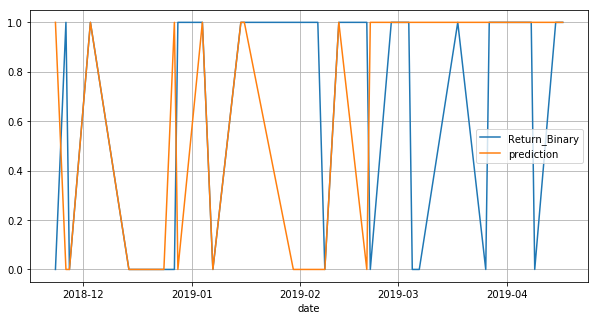

In [20]:
predictions_AAPL = predictions.where(predictions["company"]=="AAPL")
predictions_AAPL.toPandas().plot(x='date', y=['Return_Binary', 'prediction'], figsize=(10,5), grid=True)


### Predictions vs. Actual for MSFT

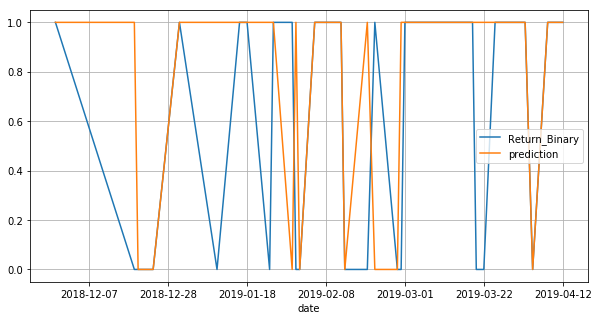

In [21]:
predictions_MSFT = predictions.where(predictions["company"]=="MSFT")
predictions_MSFT.toPandas().plot(x='date', y=['Return_Binary', 'prediction'], figsize=(10,5), grid=True)

### Predictions vs. Actual for IBM

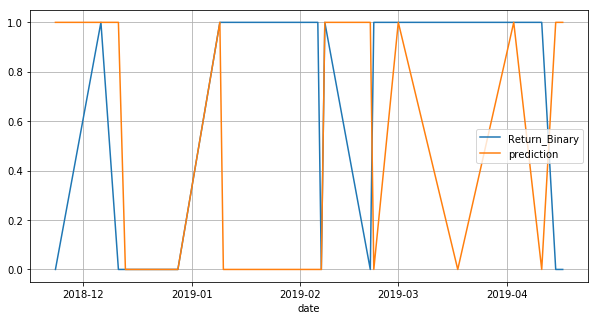

In [22]:
predictions_IBM = predictions.where(predictions["company"]=="IBM")
predictions_IBM.toPandas().plot(x='date', y=['Return_Binary', 'prediction'], figsize=(10,5), grid=True)

### Checking for accuracy on testing data

In [23]:
log_tfidf_pipeline.transform(testing_df).\
    select(fn.expr('float(prediction = Return_Binary)').alias('correct')).\
    select(fn.avg('correct')).show()

predictions = log_tfidf_pipeline.transform(testing_df)

+------------------+
|      avg(correct)|
+------------------+
|0.5925925925925926|
+------------------+



### Running regression with different regularization and elastic net parameters

In [24]:
lr2 = LogisticRegression().\
        setLabelCol('Return_Binary').\
    setFeaturesCol('tfidf').\
    setRegParam(0.02).\
    setMaxIter(100).\
    setElasticNetParam(0.2)

log_tfidf_pipeline2 = Pipeline(stages=[regexTokenizer,sw_filter, cv,idf,lr2]).fit(training_df)

lr3 = LogisticRegression().\
        setLabelCol('Return_Binary').\
    setFeaturesCol('tfidf').\
    setRegParam(0.1).\
    setMaxIter(100).\
    setElasticNetParam(0.4)

log_tfidf_pipeline3 = Pipeline(stages=[regexTokenizer,sw_filter, cv,idf, lr3]).fit(training_df)

In [25]:
pred2 = log_tfidf_pipeline2.transform(training_df)
pred3 = log_tfidf_pipeline3.transform(training_df)

### Comparing validation accuracies of different logistic regression models

In [26]:
log_tfidf_pipeline2.transform(validation_df).\
    select(fn.expr('float(prediction = Return_Binary)').alias('correct')).\
    select(fn.avg('correct')).show()

log_tfidf_pipeline3.transform(validation_df).\
    select(fn.expr('float(prediction = Return_Binary)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.6111111111111112|
+------------------+

+------------------+
|      avg(correct)|
+------------------+
|0.5555555555555556|
+------------------+



In [27]:
predictions2 = log_tfidf_pipeline2.transform(validation_df)
predictions3 = log_tfidf_pipeline3.transform(validation_df)

## 2) Logistic Regression to predict Daily Return fluctuation using Average Sentiment

### Loading sentiments dataframe

In [28]:
sentiments_df = spark.read.format("csv").option("header", "true").load("words.csv")

### Calculating Average Sentiment of Financial News

In [29]:
from pyspark.ml.feature import IDF
import requests

regexTokenizer = RegexTokenizer(inputCol="all_text", outputCol="words", pattern="\\W")
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

pipeline = Pipeline(stages=[regexTokenizer,sw_filter]).fit(news_spark_df)

output = pipeline.transform(news_spark_df)

output = output.\
   select('Date','company',fn.explode('filtered').alias('word')).\
   join(sentiments_df, 'word')

news_sentiment = output.\
    groupBy("Company","Date").\
    agg(fn.avg('Score').alias('avg_sentiment')).\
    withColumn('predicted', fn.when(fn.col('avg_sentiment') > 0, 1.0).otherwise(0.))

### Average sentiment across Dates for AAPL

[Text(0,0.5,'Average Sentiment'), Text(0.5,0,'Date')]

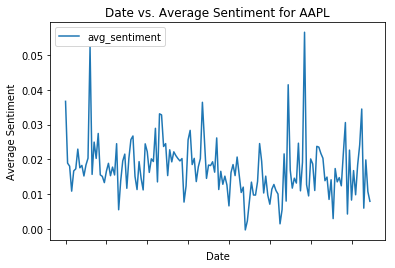

In [30]:
news_sentiment_AAPL = news_sentiment.where("Company == 'AAPL'")
plt = news_sentiment_AAPL.toPandas().plot(x='Date',y='avg_sentiment', title = 'Date vs. Average Sentiment for AAPL')
plt.set(xlabel="Date", ylabel="Average Sentiment")

### Average sentiment across Dates for MSFT

[Text(0,0.5,'Average Sentiment'), Text(0.5,0,'Date')]

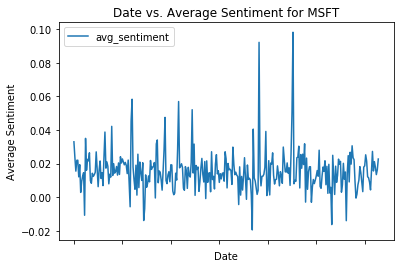

In [31]:
news_sentiment_MSFT = news_sentiment.where("Company == 'MSFT'")
plt = news_sentiment_MSFT.toPandas().plot(x='Date',y='avg_sentiment', title = 'Date vs. Average Sentiment for MSFT')
plt.set(xlabel="Date", ylabel="Average Sentiment")

### Average Sentiment across Dates for IBM

[Text(0,0.5,'Average Sentiment'), Text(0.5,0,'Date')]

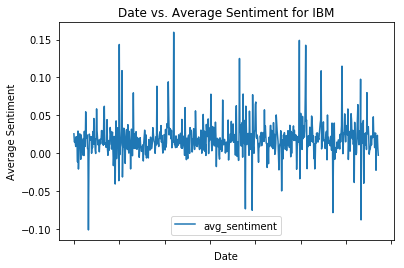

In [32]:
news_sentiment_IBM = news_sentiment.where("Company == 'IBM'")
plt = news_sentiment_IBM.toPandas().plot(x='Date',y='avg_sentiment', title = 'Date vs. Average Sentiment for IBM')
plt.set(xlabel="Date", ylabel="Average Sentiment")

### Combining news sentiment with stock prices

In [33]:
news_sentiment = news_sentiment.withColumn('Next_Date', fn.date_add(news_sentiment['Date'], 1))

combined_sentiment = news_sentiment.join(stocks_spark_df, (news_sentiment.Next_Date == stocks_spark_df.date) & (news_sentiment.Company == stocks_spark_df.Company))
combined_sentiment = combined_sentiment.drop(news_sentiment.Date)
combined_sentiment = combined_sentiment.drop(news_sentiment.Next_Date)
combined_sentiment = combined_sentiment.drop(stocks_spark_df.Company)
combined_sentiment = combined_sentiment.drop(stocks_spark_df.Close)
combined_sentiment = combined_sentiment.withColumn('Return_Binary', fn.when(fn.col('Daily Return')>0,1).otherwise(0))

### Running Logistic regression on training data

In [34]:
training_df, validation_df, testing_df = combined_sentiment.randomSplit([0.6, 0.3, 0.1], seed=100)

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
vectorAssembler = VectorAssembler(inputCols=["avg_sentiment"],
                                  outputCol="features")
lr = LogisticRegression().\
        setLabelCol('Return_Binary').\
    setFeaturesCol('features').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

log_sentiment_pipeline = Pipeline(stages=[vectorAssembler,lr]).fit(training_df)

### Cross Validation of model using validation data

In [35]:
log_sentiment_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = Return_Binary)').alias('correct')).\
    select(fn.avg('correct')).show()
predictions = log_sentiment_pipeline.transform(validation_df)
predictions.select("date", "company", "avg_sentiment","Daily Return", "Return_Binary", "probability" ,"prediction").show(10)

+------------------+
|      avg(correct)|
+------------------+
|0.5176470588235295|
+------------------+

+----------+-------+--------------------+--------------------+-------------+--------------------+----------+
|      date|company|       avg_sentiment|        Daily Return|Return_Binary|         probability|prediction|
+----------+-------+--------------------+--------------------+-------------+--------------------+----------+
|2019-04-15|    IBM| 0.00870253164556962|-0.31271716469769884|            0|[0.36882749502782...|       1.0|
|2018-11-28|   MSFT| 0.01457816377171216|    3.58171346292297|            1|[0.35923419346227...|       1.0|
|2019-03-05|   MSFT|0.013158887171561051| -0.5013428827215777|            0|[0.36154153042728...|       1.0|
|2018-12-17|   MSFT| 0.02068345323741007|  -3.051802896297017|            0|[0.34938387220164...|       1.0|
|2018-12-13|   AAPL|0.013911472448057814|  1.0821877742029802|            1|[0.36031723918906...|       1.0|
|2018-11-26|   AAPL| 0

### Predictions vs. Actual for AAPL

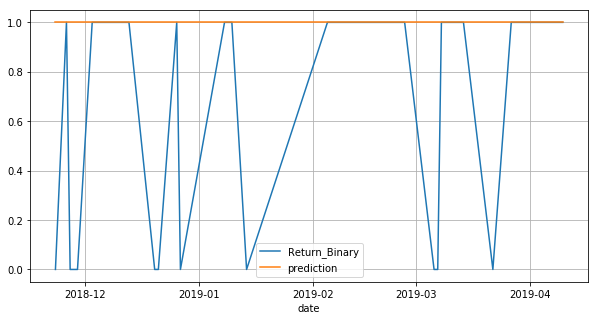

In [36]:
predictions_AAPL = predictions.where(predictions["company"]=="AAPL")
predictions_AAPL.toPandas().plot(x='date', y=['Return_Binary', 'prediction'], figsize=(10,5), grid=True)


### Checking for accuracy on testing data

In [37]:
log_sentiment_pipeline.transform(testing_df).\
    select(fn.expr('float(prediction = Return_Binary)').alias('correct')).\
    select(fn.avg('correct')).show()
predictions = log_sentiment_pipeline.transform(testing_df)

+------------+
|avg(correct)|
+------------+
|         0.5|
+------------+



### Running regression with different regularization and elastic net parameters

In [38]:
lr2 = LogisticRegression().\
        setLabelCol('Return_Binary').\
    setFeaturesCol('features').\
    setRegParam(0.02).\
    setMaxIter(100).\
    setElasticNetParam(0.2)

log_sentiment_pipeline2 = Pipeline(stages=[vectorAssembler,lr2]).fit(training_df)

lr3 = LogisticRegression().\
        setLabelCol('Return_Binary').\
    setFeaturesCol('features').\
    setRegParam(0.1).\
    setMaxIter(100).\
    setElasticNetParam(0.4)

log_sentiment_pipeline3 = Pipeline(stages=[vectorAssembler,lr3]).fit(training_df)

### Comparing validation accuracies of different logistic regression models

In [39]:
pred2 = log_sentiment_pipeline2.transform(validation_df)
pred3 = log_sentiment_pipeline3.transform(validation_df)

log_sentiment_pipeline2.transform(validation_df).\
    select(fn.expr('float(prediction = Return_Binary)').alias('correct')).\
    select(fn.avg('correct')).show()

log_sentiment_pipeline3.transform(validation_df).\
    select(fn.expr('float(prediction = Return_Binary)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.5176470588235295|
+------------------+

+------------------+
|      avg(correct)|
+------------------+
|0.5176470588235295|
+------------------+



## 3) Linear Regression to predict Daily Return using TF-IDF ouput

### Performing tokenizing, count vectorizing and TFIDF

In [40]:
from pyspark.ml.feature import IDF
import requests

regexTokenizer = RegexTokenizer(inputCol="combined_text", outputCol="words", pattern="\\W")
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

cv = CountVectorizer(minTF=1., minDF=1., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

idf_pipeline = Pipeline(stages=[regexTokenizer,sw_filter, cv,idf])

### Linear regression on training data

In [41]:
combined_data = combined_data.na.fill(0)
training_df, validation_df, testing_df = combined_data.randomSplit([0.6, 0.3, 0.1], seed=100 )


linearRegression = regression.LinearRegression(featuresCol = 'tfidf', labelCol = 'Daily Return')
pipe_model_best =  Pipeline(stages=[regexTokenizer,sw_filter, cv,idf, linearRegression])
linear_tfidf_pipeline = pipe_model_best.fit(training_df)

pipe_model =  Pipeline(stages=[regexTokenizer,sw_filter, cv,idf]).fit(training_df)


### Cross validation of model on validation data

In [42]:
data = pipe_model.transform(validation_df)
lr1=linearRegression.fit(data)

predictions = linear_tfidf_pipeline.transform(validation_df)
rmse = fn.sqrt(fn.mean((fn.col('Daily Return') - fn.col('prediction'))**2)).alias('rmse')
rmse1_df = linear_tfidf_pipeline.transform(validation_df).select(rmse)
rmse1_df.show()

validationSummary = lr1.summary
print("r2: %f" % validationSummary.r2)


+------------------+
|              rmse|
+------------------+
|2.2181663623758645|
+------------------+

r2: 1.000000


### Predictions vs. Actual for AAPL

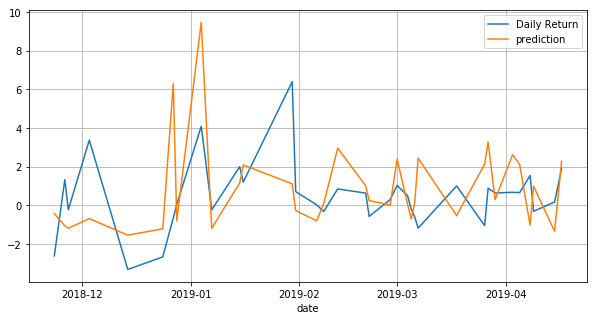

In [43]:
predictions_AAPL = predictions.where(predictions["company"]=="AAPL")
predictions_AAPL.toPandas().plot(x='date', y=['Daily Return', 'prediction'], figsize=(10,5), grid=True)


### Predictions vs. Actual for MSFT

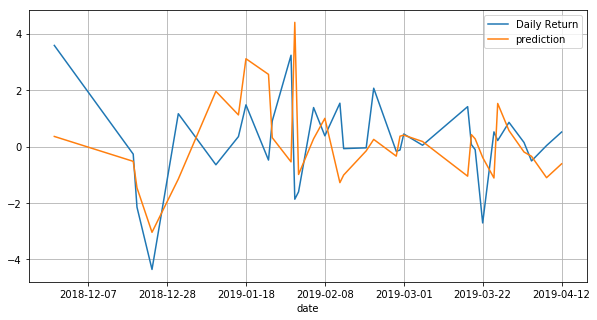

In [44]:
predictions_MSFT = predictions.where(predictions["company"]=="MSFT")
predictions_MSFT.toPandas().plot(x='date', y=['Daily Return', 'prediction'], figsize=(10,5), grid=True)


### Checking for accuracy on testing data

In [45]:
data = pipe_model.transform(testing_df)
lr1=linearRegression.fit(data)

predictions = linear_tfidf_pipeline.transform(testing_df)
rmse = fn.sqrt(fn.mean((fn.col('Daily Return') - fn.col('prediction'))**2)).alias('rmse')
rmse1_df = linear_tfidf_pipeline.transform(testing_df).select(rmse)
rmse1_df.show()

validationSummary = lr1.summary
print("r2: %f" % validationSummary.r2)

+-----------------+
|             rmse|
+-----------------+
|2.816750085654239|
+-----------------+

r2: 1.000000


## 4) Linear Regression to predict Daily Return using Average Sentiment

### Running linear regression on training data

In [46]:
combined_sentiment = combined_sentiment.na.fill(0)
training_df, validation_df, testing_df = combined_sentiment.randomSplit([0.6, 0.3, 0.1], seed=100)

vectorAssembler = VectorAssembler(inputCols=['avg_sentiment'], outputCol = 'feature')

linearRegression = regression.LinearRegression(featuresCol = 'feature', labelCol = 'Daily Return')
linear_sentiment_pipeline =  Pipeline(stages=[vectorAssembler, linearRegression]).fit(training_df)


### Cross validation of model on validation data

In [47]:
rmse = fn.sqrt(fn.mean((fn.col('Daily Return') - fn.col('prediction'))**2)).alias('rmse')
rmse1_df = linear_sentiment_pipeline.transform(validation_df).select(rmse)
rmse1_df.show()

vectorizedData = vectorAssembler.transform(validation_df)
lrModel = linearRegression.fit(vectorizedData)


predictions = linear_sentiment_pipeline.transform(validation_df)

validationSummary = lrModel.summary
print("r2: %f" % validationSummary.r2)

+------------------+
|              rmse|
+------------------+
|1.7313813147510977|
+------------------+

r2: 0.009952


### Predictions vs. Actual for AAPL

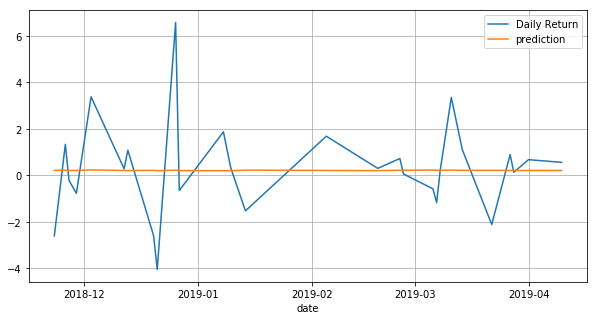

In [48]:
predictions_AAPL = predictions.where(predictions["company"]=="AAPL")
predictions_AAPL.toPandas().plot(x='date', y=['Daily Return', 'prediction'], figsize=(10,5), grid=True)


### Checking for accuracy on testing data

In [49]:
rmse = fn.sqrt(fn.mean((fn.col('Daily Return') - fn.col('prediction'))**2)).alias('rmse')
rmse1_df = linear_sentiment_pipeline.transform(testing_df).select(rmse)
rmse1_df.show()

vectorizedData = vectorAssembler.transform(testing_df)
lrModel = linearRegression.fit(vectorizedData)

testingSummary = lrModel.summary
print("r2: %f" % testingSummary.r2)

+-----------------+
|             rmse|
+-----------------+
|1.351899543867174|
+-----------------+

r2: 0.006305


## Predicting based on user input

In [152]:
all_text="Apple is an amazing company with the best technological innovation and a pragmatic CEO"

### Predictions using TF-IDF

In [153]:
input = pd.DataFrame({'combined_text':all_text},index=[0])
abc = spark.createDataFrame(input)
linear_predictions = linear_tfidf_pipeline.transform(abc)
logistic_predictions = log_tfidf_pipeline.transform(abc)

In [154]:
linear_predictions.select("combined_text", "filtered", "tf","tfidf","prediction").show()

+--------------------+--------------------+--------------------+--------------------+-------------------+
|       combined_text|            filtered|                  tf|               tfidf|         prediction|
+--------------------+--------------------+--------------------+--------------------+-------------------+
|Apple is an amazi...|[apple, amazing, ...|(16788,[1,5,84,92...|(16788,[1,5,84,92...|-0.9061514894071888|
+--------------------+--------------------+--------------------+--------------------+-------------------+



In [155]:
logistic_predictions.select("combined_text", "filtered", "tf","tfidf","prediction").show()

+--------------------+--------------------+--------------------+--------------------+----------+
|       combined_text|            filtered|                  tf|               tfidf|prediction|
+--------------------+--------------------+--------------------+--------------------+----------+
|Apple is an amazi...|[apple, amazing, ...|(16788,[1,5,84,92...|(16788,[1,5,84,92...|       1.0|
+--------------------+--------------------+--------------------+--------------------+----------+



### Predictions using Average Sentiment

In [156]:
input = pd.DataFrame({'all_text':all_text},index=[0])
abc = spark.createDataFrame(input)
output = pipeline.transform(abc)

output = output.\
   select(fn.explode('filtered').alias('word')).\
   join(sentiments_df, 'word')

news_sentiment = output.\
    agg(fn.avg('Score').alias('avg_sentiment')).\
    withColumn('predicted', fn.when(fn.col('avg_sentiment') > 0, 1.0).otherwise(0.))

linear_predictions = linear_sentiment_pipeline.transform(news_sentiment)
logistic_predictions = log_sentiment_pipeline.transform(news_sentiment)

In [157]:
linear_predictions.show()
logistic_predictions.show()

+-------------------+---------+--------------------+------------------+
|      avg_sentiment|predicted|             feature|        prediction|
+-------------------+---------+--------------------+------------------+
|0.11538461538461539|      1.0|[0.11538461538461...|0.3785247138782176|
+-------------------+---------+--------------------+------------------+

+-------------------+---------+--------------------+--------------------+--------------------+----------+
|      avg_sentiment|predicted|            features|       rawPrediction|         probability|prediction|
+-------------------+---------+--------------------+--------------------+--------------------+----------+
|0.11538461538461539|      1.0|[0.11538461538461...|[-1.2896518141029...|[0.21591175072865...|       1.0|
+-------------------+---------+--------------------+--------------------+--------------------+----------+



## Inference

Predicting stock price daily return fluctuation is more accurate while using TF-IDF and less accurate while using average sentiment ratings

The model results are as follows:

Logisitic regression to predict daily return fluctuation (binary outcome) using TF-IDF of news : 58.8% accuracy
Logisitic regression to predict daily return fluctuation (binary outcome) using average sentiment of news : 51% accuracy
Linear regression to predict daily return fluctuation using TF-IDF of news: RMSE 2.21 (daily return percentage)
Linear regression to predict daily return fluctuation using average sentiment of news: RMSE 1.73 (daily return percentage) but the model has a low R-squared

As an example, when a news article as following is published:
"Apple is an amazing company with the best technological innovation and a pragmatic CEO"

The logistic regression model based on TF-IDF and based on sentiment rating is able to predict that the closing price will rise and therefore the daily return change will be positive.
The linear regression model based on sentiment predicts that the closing price will rise by 0.37% from the previous day
